# Generation of training dataset

In [1]:
import os
import matplotlib.pyplot as plt
import segyio
from tqdm import tqdm
from utils import *
%config InlineBackend.figure_formats =['png']
plt.style.use('seaborn-ticks')

# Set the destination folder for the generated data

path = '../dataset'
obj = 'test'  # Change from training to testing to create more velocity models for testing

ModuleNotFoundError: No module named 'disba'

In [15]:
if os.path.exists(path + "/{}".format(obj)):
    os.system("rm -rf " + path + "/{}".format(obj))
os.mkdir(path + "/{}".format(obj))
os.mkdir(path + "/{}/data".format(obj))
os.mkdir(path + "/{}/data_su".format(obj))
os.mkdir(path + "/{}/label".format(obj))
os.mkdir(path + "/{}/model".format(obj))
os.mkdir(path + "/{}/snaps".format(obj))

## Creation of models

In [16]:
mods = []
N = 100  # Set the number of models to generate

for n in tqdm(range(N)):
    mods.append(
        VelModel(
            50,  # Maximum depth to reach
            4,  # Number of layers in the model
            200,  # Min value of Vs used for the model
            1000,  # Max value of Vs used for the model
            random_range=80,  # Allowed variation range for Vs
            ranvar=True,  # Random layers boolean
            first_mode=False,  # Generate dispersion curves for first and fundamental modes
            minran1=3,  # Min allowed thickness for first layer
            maxran1=15,  # Max allowed thickness for first layer
            maxranf=20,  # Max allowed thickness for following layers
            sizex=50,  # Size of the model
            counter=n,  # Counter for the models
            maxfreq=60,  # Maximum frequency to model dispersion curves
            save_data=True,  # Save data to given folder
            path=f"{path}/{obj}",  #Path of the destination
            dx=0.5,  # FD modeling parameter, might require changes
        )
    )


100%|██████████| 100/100 [00:07<00:00, 13.89it/s]


Update the values for dx in the models already created

In [18]:
need_change = checkdx(mods)  # Checks if the models generated are stable for fdelmodc

if need_change:
    dx = 0.51  # Change this value accordingly to the previous result, if no feasible value, change Vs ranges
    for mod in mods:
        setattr(mod, 'dx', dx)
        mod.get_message()
    print('The new value for dx is {}'.format(dx))

    checkdx(mods)

else:
    print('No need to change the parameters')


No need to change the parameters


## Creation of wavelet

    makewave: Flat spectrum wavelet
    makewave: ---------------------
    makewave: Number of time samples .. = 12300
    makewave: time step ............... = 0.000100 (s)
    makewave: maximum frequency ....... = 60.000000 Hz
    makewave: left cut-off frequency .. = 10.000000 Hz
    makewave: right cut-off frequency . = 50.000000 Hz
    makewave: minimum frequency ....... = 5.000000 Hz
    makewave: time shift .............. = 0.230000 (s)


The command executed successfully!


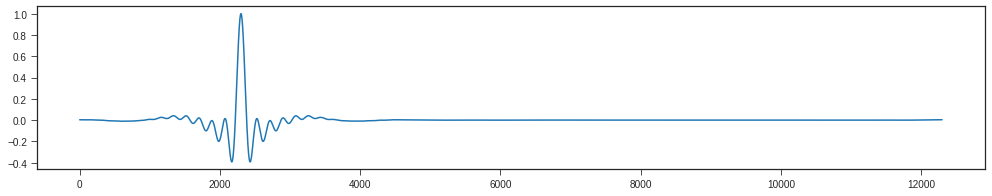

In [19]:
# Creating wavelet
dt = 0.0001  # Stepsize in time direction
t0 = 0.23  # Position of peak wavelet
nt = (1 + t0) / dt

w = "fw"  # Type of wavelet
fmin = 5
flef = 10
frig = 50
fmax = 60

wavelet = "makewave file_out=wavelet.su dt={} nt={} t0={} w={} fmin={} flef={} frig={} fmax={} verbose=1".format(
    str(dt), str(nt), str(t0), w, str(fmin), str(flef), str(frig), str(fmax)
)

running = os.system(
    "cd {pathstr}/{obj}/ && {wvstr}".format(pathstr=path, obj=obj, wvstr=wavelet)
)

if running == 0:
    print("The command executed successfully!")

waveimage = segyio.su.open(path + "/{}/".format(obj) + "wavelet.su", endian="little")
plt.figure(figsize=(17, 3))
plt.plot(waveimage.trace[0])
waveimage.close()


In [21]:
%%time

# Creating model profiles
for nm in tqdm(range(N)):
    os.system('cd ' + path + '/{}/ && '.format(obj) + mods[nm].message)

100%|██████████| 100/100 [00:01<00:00, 52.54it/s]

CPU times: user 68.8 ms, sys: 846 ms, total: 915 ms
Wall time: 1.91 s


## Finite difference modeling

In [22]:
file_src = 'wavelet.su'

xrcv1 = 15  # Initial offset
xrcv2 = 39  # Final offset
dxrcv = 1  # Receiver offset
dtrcv = 0.0005  # Receiver time resolution
xsrc = 0  # Offset of the source

for m in tqdm(range(N)):
    file_cp = str(m) + '_cp.su'
    file_cs = str(m) + '_cs.su'
    file_den = str(m) + '_ro.su'
    file_rcv = str(m) + '.su'
    file_log = str(m) + '.log'
    file_snap = None  # str(m) + 'snap.su'

    modeling = 'fdelmodc file_cp={} file_cs={} file_den={} ischeme=3 file_src={} file_rcv={} file_snap={}' \
               ' xrcv1={} xrcv2={} dxrcv={} zrcv1=0 zrcv2=0 dtrcv={} rec_type_vx=1 rec_type_vz=1 rec_int_vx=1 rec_int_vz=0 xsrc={}' \
               ' zsrc=0 nshot=1 src_type=7 src_orient=1 top=1 left=4 right=4 bottom=4 ntaper=100 verbose=4 > {} 2>&1'.format(
        file_cp, file_cs, file_den, file_src, file_rcv, file_snap, xrcv1, xrcv2, dxrcv, dtrcv, xsrc, file_log)

    os.system('cd ' + path + '/{}/ && '.format(obj) +
              'export OMP_NUM_THREADS=16 && ' + modeling)  #+ snap_string)

100%|██████████| 100/100 [03:11<00:00,  1.92s/it]


#### Organizing files

In [23]:
os.system('cd ' + path + f'/{obj} && ' + 'mv *_rvz.su data_su/')
os.system('cd ' + path + f'/{obj} && ' + 'mv *snap*.su snaps/')
os.system('cd ' + path + f'/{obj} && ' + 'rm -rf  *.log && rm -rf  *.txt && rm -rf  *.su')

mv: cannot stat '*snap*.su': No such file or directory


0